# MNIST Handwritten Digit Classifier

## Introduction

This notebook uses logistic regression as a one-vs-all multi-class classification of the 0 through 9 handwritten digits in the MNIST dataset. A detailed description of the dataset and a catolog of previous analysis on the datset can be found here: http://yann.lecun.com/exdb/mnist/. 

## Future Work

Ideas for improvement
 - prettify the notebook
 - plot the cost functions
 - apply SVM's
 - apply neural networks
 - optimize alpha (and lambda)
 - add regularization

In [65]:
import numpy as np
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt
import time

## The Dataset

The dataset was downloaded from http://yann.lecun.com/exdb/mnist/ and then unzipped. The data was then processed using the mlxtend.data library outlined here:  https://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/

In [2]:
X_train_org, y_train_org = loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')

X_test_org, y_test_org = loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')

The images of each digit are made up for 28 x 28 pixels (784 total), which have been reformatted into a single vector of length 784. There are 60,000 images in the training set and 10,000 in the test set. The y_train and y_test are oddly shaped, which is a concern, though it doesn't effect the analyis in the end. I tried to remedy this using the np.squeeze function, but it didn't work. 

In [3]:
print('X_train dimensions: %s x %s' % (X_train_org.shape[0], X_train_org.shape[1]))
print('y_train dimensions:'+ str(y_train_org.shape )) 
print('X_test dimensionss: %s x %s' % (X_test_org.shape[0], X_test_org.shape[1]))
print('y_test dimensions:'+ str(y_test_org.shape )) 
print('Example of X_train:', X_train_org[0:15,0:15])
print('Example of y_train:', y_train_org[0:15])

X_train dimensions: 60000 x 784
y_train dimensions:(60000,)
X_test dimensionss: 10000 x 784
y_test dimensions:(10000,)
Example of X_train: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Example of y_train: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1]


Below are images of what a given example of the handwritten digits look like. 

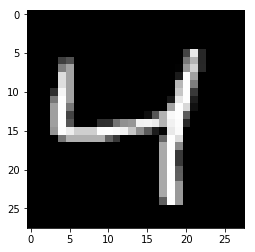

In [4]:
example_number = 2
img = X_train_org[example_number,:].reshape(28,28)
plt.imshow(img, cmap='gray')

The data is currently formatted with the rows being the nummber of examples, (m=60,000), and the columns being the features, (n=784). The analysis I will perform has the data transposed, with size n x m, which will be done below. Additionally, I have scaled the data to be within zero and 1 by dividing by 255, as the pixel values are 8-bit integers. 
I remedied the missing column values in y_train and y_test with by putting them inside a np.array and transposed the y-values as well. 

In [20]:
X_train = X_train_org.T/255
X_test = X_test_org.T/255

y_train = np.array([y_train_org.T])
print(y_train.shape)
y_test = np.array([y_test_org.T])

#training data for only the one-digit which will be used to test the single-digit classifier
y_train_ones = y_train ==1
y_test_ones = y_test ==1

(1, 60000)


## Methods

The methodology of using binary classification in one-vs-all multiclassification is outlined briefly here: http://mlwiki.org/index.php/One-vs-All_Classification. A binary classifier using logistic regression will be trained separately for each digit. This means that the dataset will be modified where only zero's are a positive result (y=1) and all other digits are a negative result (y=0). The binary classifier will then be trained to identify zero's (y=1) resulting in a weights matrix (generally denoted W, but denoted W0 for the weights of the zero classifier) and the bias vector, b (also denoted b0 for the zero classifier). 

10 classifiers will be trained for each digit each with their own weights (W) and bias (b). Then, each example will be run through the 10 classifiers and the classifier that yields the greatest value, indicating the strongest classification, will be chosen. Through this way, the entire dataset can be used to classified.

In [6]:
def initialize():
    '''
    Description
    This funciton initializes the parameters in the classifier with the W-weights initialized to small random
        numbers and the bias term, b, intialized to zeros.
    
    Input
    For a simple classifier, no inputs are needed because there is only a single W matrix and a single b-vector.
    For a neural network, separate weight matricies and bias vectors need to be created for each layer.
    
    Output
    W - the weight matrix
    b - the bias vector
    
    '''
    
    np.random.seed(2) #sets the seed of the random number generator
    
    W = np.random.randn(1, X_train.shape[0])*0.01
    #the '[0]' term below is used to strip one set of square brackets off b so that its shape is consisent with db below
    b = np.zeros((1,1))
  
    
    #the assert statements are used to ensure the W and b matricies have the correct shape.
    assert(W.shape == (1, X_train.shape[0]))
    assert(b.shape == (1,1))
        
    return W, b
    

In [7]:
#this commmented command can be used to check the output of the initialize fuction
#initialize()

In [8]:
def sigmoid(x):
    '''
    Description
    The sigmoid function, which is used in logistic regression.
    
    Input
    A value or np.array, x
    
    Ouput
    The sigmoid of the input
    '''
    
    sig = 1/(1+np.exp(-x))
    
    return sig

At large negative values, the sigmoid function outputs zero; at zero, the sigmoid outputs 0.5; and at large positive values, the sigmoid outputs one.

In [9]:
sig_test = np.array([-10,0,10])
sigmoid(sig_test)

array([4.53978687e-05, 5.00000000e-01, 9.99954602e-01])

I don't think I need the function for the deriviative of the sigmoid, but I wrote it anyway. I should probably delete the function

In [10]:
def deriv_sigmoid(x):
    '''
    Description
    The derivative of the sigmoid function
    
    '''
    
    d_sig = sigmoid(x) * (1 - sigmoid (x))
    
    return d_sig

At large negative values, the derivative outputs zero; at zero, the derivative is 0.25; and at large positive values, the derivative is also zero.

In [11]:
d_sig_test = np.array([-10,0,10])
deriv_sigmoid(d_sig_test)

array([4.53958077e-05, 2.50000000e-01, 4.53958077e-05])

In [12]:
def forward_prop(W, b, X):
    '''
    Description
    This function calculates the forward progagation of logistic regression. Here the activation function is
        the sigmoid function
    
    Input
    W - the weight matrix
    b - the bias bector
    X - the input data
    
    Output
    Z - the linear multiplication of W and X added to the bias term, b
    A - the activation value, which is the activation function computed on the Z-value
    
    '''
    
    Z = np.dot(W, X) + b
    A = sigmoid(Z)    
        
    return A, Z

The propagation function which conducts the forward propagation step, computes the cost function, and updates the W and b terms using gradient descent. Gradient descent is done by calculating the derivative of the cost function with respect to the W and b terms. This derivative is calculated using the chain rule. 

The best concise description I can find for this is here: https://medium.com/technology-nineleaps/logistic-regression-gradient-descent-optimization-part-1-ed320325a67e - through this article doesn't derive the derivative calculations, dW (which is shorthand for $\partial$C/$\partial$W where C is the cost funcition) and db (which is also $\partial$C/$\partial$b).

In [13]:
def propagate(X, W, b, Y):
    '''
    Description
    Calles the forward_prop function top conduct forward propogation, calculates the cost function, and calculates
        the derivatives of the cost function with respect to W and b to implement gradient descent to update W and b.
    
    Input
    X   - the training data
    W   - the weights
    

    Output
    cost    - the cost function calculated
    dW   - the gradient of the W-weight
    db   - the gradient of the bias term, b
    '''
    

    A, Z = forward_prop(W, b, X)
    
    m = A.shape[1]
    
    #calculating the cost function of logistic regressions
    cost = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1-A), axis=1) 
    
    #calculates the gradients of W and b
    dW = 2/m * np.dot(A - Y, X.T)
    db = np.array([1/m * np.sum(A - Y, axis=1)])
    #print(db.shape)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)

            
    return cost, dW, db

In [29]:
def single_digit_classifier(X_train, Y_train, learning_rate=0.1, iterations = 500, print_cost = True):
    '''
    Description
    Runs the logistic regression for a single digit

    Inputs
    X_train - the input features of the training data
    Y_train - the labels of the digits in the training set
    learning_rate - the learning rate used in gradient descent, set to 0.1 by default
    iternations - the number of iterations of the gradient descent, set to 500 by default
    print_cost - a binary label to see if the cost of of every 100 iterations will be printed
    
    Outputs
    W - the final value of the W-weight optimized by gradient descent
    b - the final value of the b bias term optimized by gradient descent
    costs - a list of the costs calculated over the iterations
    
    '''
    
    costs = []
    W, b = initialize()
    
    for i in range(iterations):

        cost, dW, db = propagate(X_train, W, b, Y_train)
        
        W = W - learning_rate * dW
        b = b - learning_rate * db
        
        
        #if print_cost & i % 100 == 0:
        #    print('Cost for ' + str(i) + '= ' + str(cost) ) 
    
    
    return W, b, costs

In [16]:
sd  = single_digit_classifier(X_train, y_train_ones)

In [21]:
def single_digit_error(X,W,b, y):
    '''
    Description
    Calculates the error of the predictions for the single digit classifier. In this function, the classifier is
        seen to "predict" a certain value if the A-values are greater than 0.5, which is the classification threshold.
        This will not be how the error is calculate or how prediction is calculated with multiple digits. 
    
    Inputs
    The usual suspects
    
    Ouput
    The error term which is the average deviation of the predictions from the y-labels
    '''
    
    A, Z = forward_prop(W,b,X)
    
    predictions = A>0.5*1.0
    
    m = predictions.shape[1]
    
    error = 1/m * np.sum(predictions!=y)
    
    return error

Running the error function for the single digit classifier

In [31]:
single_train_error = single_digit_error(X_train, sd[0], sd[1], y_train_ones)
single_test_error = single_digit_error(X_test, sd[0], sd[1], y_test_ones)
print('Training set error: ', single_train_error)
print('Test set error: ', single_test_error)


Training set error:  0.01175
Test set error:  0.0083


()

The method of making predictions in the single_digit_error calculator is likely inaccurate as the training set error and test set errors are too small when seen in the context of the performance of other learning algorithms on this dataset, as shown here: http://yann.lecun.com/exdb/mnist/. The lowest error on the dataset was 0.23 from using a 35 layer neural network. Granted, the error calculated above is only for classifying a single digit, while the 0.23 is for classifying all digits. One potential reason why our single digit classifer is doing so well could be do to the low frequency of positive events (y=1). There are around 6,500 ones in the dataset, which is roughly 10% of the dataset, which means that even if no learning occured and the algorithm always predicted a y=0, it would have a 10% error rate. 

I won't spend too much time disecting the reason for the low error rate, as simply classifying ones is only 1/10 of the stated mission. 

## Multi-digit Classifier

In [28]:
def multi_digit_classifier(X_train, y_train, learning_rate):
    '''
    Description
    This function calls the single_digit_classifier fuction on every number in the data set (0-9), which generates
    W and b values for each digit. 
    
    Input
    X_train - the features in the training set
    y_train - the labels of the features in the training set
    learning_rate - the learing rate used in gradient descent - it is an input to the single_digit_classifier
    
    Output
    parameters - a dictionary of the W and b parameters for each digit classifier with labels 'W0' for the 
        W-weight of the zero classifier and 'b0' for the b-term of the zero classifier.
        
    '''
    
    parameters = {}
#   cost_dic = {}
    m = X_train.shape[1]
    
    for i in range(10):
        y_train_temp = y_train ==i
        W, b, costs = single_digit_classifier(X_train, y_train_temp, learning_rate)
        parameters['W_'+str(i)] = W
        parameters['b_'+str(i)] = b
#        costs['costs_'+str(i)] = costs


    return parameters

Running the multi-digit classifier. The classifier takes almost 3 minutes to run, which doesn't bode well for parameter tuning. In future work, I will consider how to reduce the number of for-loops to try to speed up the computation time.

In [57]:
time1 = time.time()
multi_digit_parameters = multi_digit_classifier(X_train, y_train, learning_rate=0.1)
time2 = time.time()
print('Minutes to run classifier: ', (time2-time1)/60 )

Time to run classifier:  193.93325185775757


In [58]:
def multi_digit_predict(parameters, X):
    '''
    Description
    This function uses the parameters of the multi_digit_classifier to calculate the A-values for each single 
        digit classifier and takes the digit with the maximum A-value as the predicted digit.
    
    Input
    parameters - the W and b values for each single digit classifier outputted from the multi_digit_classifier
    X          - the the feature data that will be used along with the parameters to calculate the A-values 
    
    Output
    predictions - a list of the predicted numbers for each of the examples in the dataset, X
    
    '''
    
    A_values, Z = forward_prop(parameters['W_'+str(0)], parameters['b_'+str(0)], X)
    for i in range(1,10):
        A_temp, Z = forward_prop(parameters['W_'+str(i)], parameters['b_'+str(i)], X)
        A_values = np.append(A_values, A_temp, axis=0)
    
    predictions = []
    for j in range(X.shape[1]):
        predictions.append(np.argmax(A_values[:,j]))
    
    assert(len(predictions) == X.shape[1])
    
    return predictions

In [60]:
multi_train_predictions = multi_digit_predict(multi_digit_parameters, X_train)
multi_test_predictions = multi_digit_predict(multi_digit_parameters, X_test)

print('A sample of the predictions: ',all_train_predictions[0:15])

A sample of the predictions:  [5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1]


In [63]:
def multi_digit_error(predictions, y):
    '''
    Description
    This function calculates the error for the multi_digit_classifier my taking the average number of incorrrect
    classifications of the y-labels in the training set.
    
    Inputs
    predictions - the predictions of the digits in each image, the output the multi_digit_predict function
    y - the labels of the training set data
    
    Outputs
    error - the average number of incorrect classifications
    
    '''
    
    m = len(predictions)
    error = 1/m * np.sum(predictions!=y)
    
    return error

In [64]:
multi_train_error = multi_digit_error(multi_train_predictions,y_train)
multi_test_error = multi_digit_error(multi_test_predictions,y_test)
print("Multi-digit training error: "+ str(train_all_error))
print("Multi-digit test error: "+ str(test_all_error))

Multi-digit training error: 0.10681666666666667
Multi-digit test error: 0.0995


The error on the training set is around 10.6% and is comparable to the 10% test set error. Both of these errors seem reasonable in the context of the performance of other learning algorithms as shown at: http://yann.lecun.com/exdb/mnist/. The error rate of a linear classifier is 12%. 

By comparing the training and test set errors, we can gain insight into the learning algorithm. If the training set error was small compared to the test set error, then the model would have high variance (overfitting). If the training set error was large compared to what we would expect the model to perform, then the model would have high bias (underfitting). Since the training and test set errors are very close, the model is does not have high variance, and since it is performing fairly well compared to the 12% error of a linear classifier, the model does not suffer from high bias, either. 

Adding regularization is a logical next step to improve the performance; however, since the model doesn't suffer from high variance, adding regularization is unlikely to improve the performance dramatically. Instead, it may be better to increase the model's complexity by turning it into a neural network and then add regularization, which will be be the next step in this exercise. 

Or instead, I may analzye the same problem using SVM's to buff up on their application.